# Customer Segmentation #

### Import required packages ###

In [1047]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Read file ###

In [1048]:
mall_data = pd.read_csv('Mall_Customers.csv')
mall_data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [1049]:
mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [1050]:
mall_data.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [1051]:
mall_data.isna().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [1052]:
mall_data.duplicated().sum()

np.int64(0)

### Plot current data ###

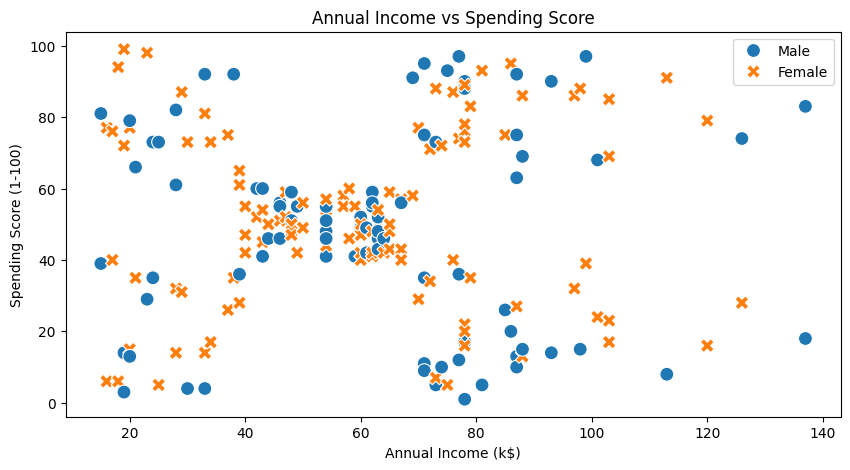

In [1053]:
# plot Annual Income vs Spending Score
plt.figure(figsize=(10,5))
sns.scatterplot(data=mall_data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Genre', style='Genre', s=100)
plt.title('Annual Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [1054]:
X = mall_data[['Annual Income (k$)', 'Spending Score (1-100)']]

In [1055]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### To find optimal number of clusters, use Elbow Method or Silhouette Analysis ###

In [1056]:
from sklearn.metrics import silhouette_score


inertia = []
sillhouette = []
K = range(1, 11)
for k in K:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)
    if k > 1:
        sillhouette.append(silhouette_score(X_scaled, model.labels_))

Optimal number of clusters: 5


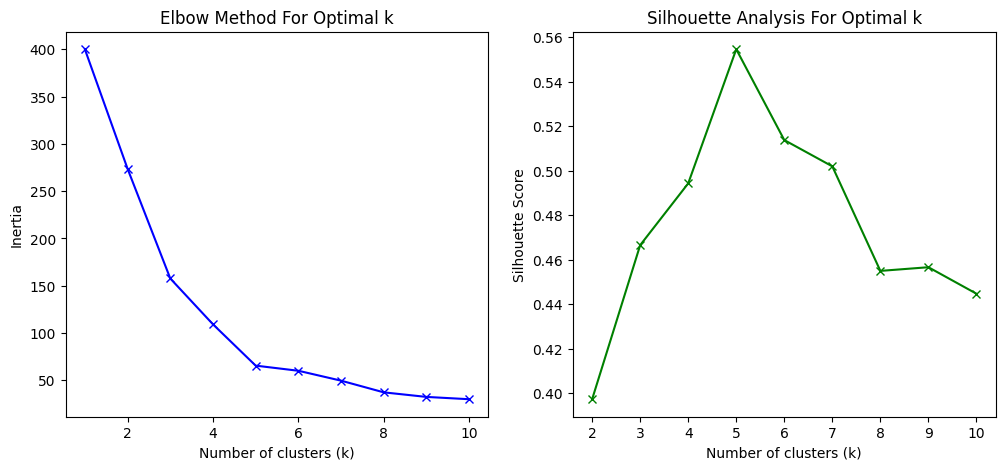

In [1057]:
plt.figure(figsize=(12,5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Silhouette Analysis
plt.subplot(1, 2, 2)
plt.plot(K[1:], sillhouette, 'gx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')

# getting the optimal number of clusters from silhouette analysis
optimal_clusters = sillhouette.index(max(sillhouette)) + 2  # +2 because sillhouette list starts from k=2
print(f'Optimal number of clusters: {optimal_clusters}')

### Creating the model ###

In [1058]:
model = KMeans(n_clusters = optimal_clusters, random_state = 42)
mall_data['Cluster'] = model.fit(X_scaled).labels_
mall_data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4


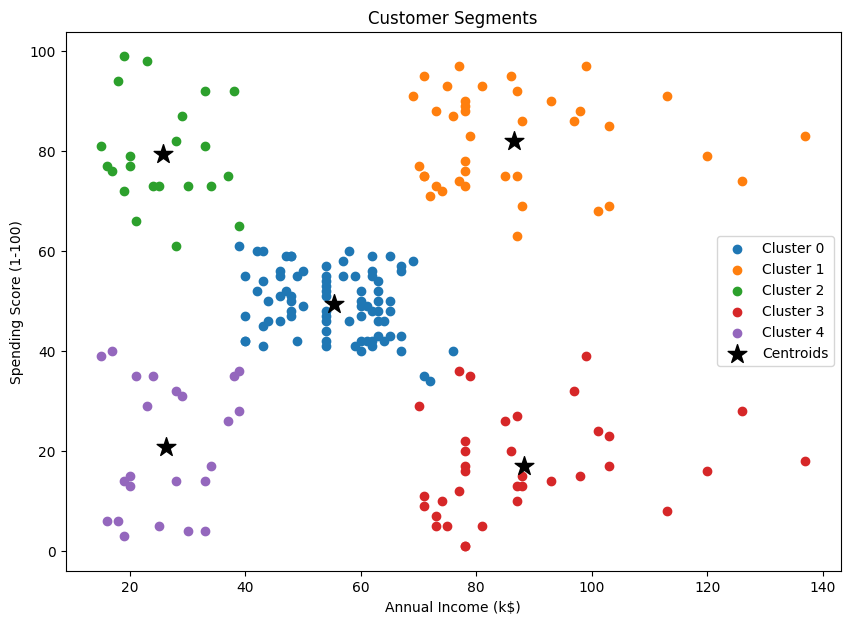

In [1059]:
plt.figure(figsize=(10,7))
for i in range(optimal_clusters):
    cluster_data = mall_data[mall_data['Cluster'] == i]
    plt.scatter(cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'], label=f'Cluster {i}', alpha=1)

original_centers = scaler.inverse_transform(model.cluster_centers_)
plt.scatter(original_centers[:, 0], original_centers[:, 1], s=200, c='black', marker='*', label='Centroids')

plt.legend()
plt.title('Customer Segments')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [1060]:
print('Number of customers in each cluster:')
print(mall_data['Cluster'].value_counts())
print('\n')
cluster_summary = mall_data.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(cluster_summary)

Number of customers in each cluster:
Cluster
0    81
1    39
3    35
4    23
2    22
Name: count, dtype: int64


         Annual Income (k$)  Spending Score (1-100)
Cluster                                            
0                 55.296296               49.518519
1                 86.538462               82.128205
2                 25.727273               79.363636
3                 88.200000               17.114286
4                 26.304348               20.913043


### Using DBSCAN ###

DBSCAN Results: 3 clusters, 8 noise points


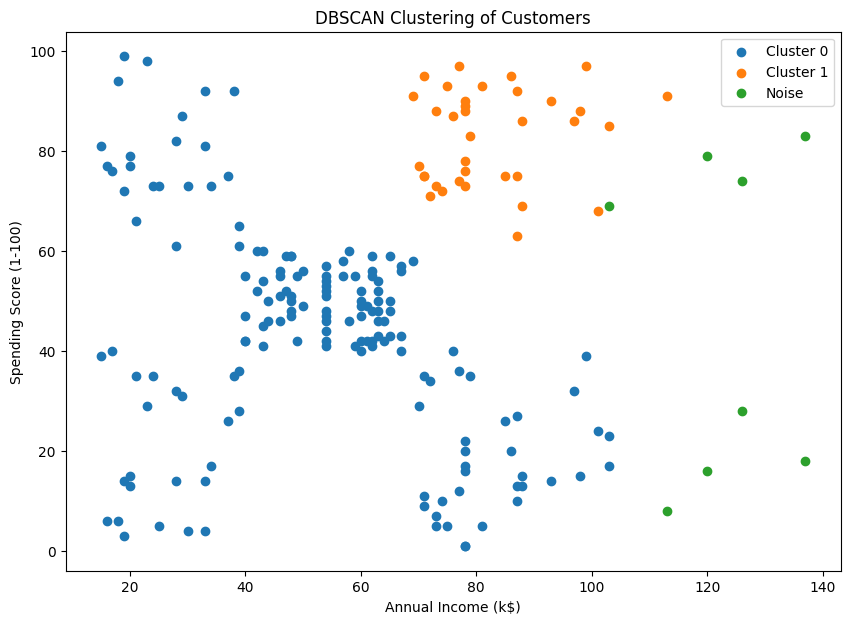

Number of customers in each cluster:
DBSCAN_Cluster
 0    157
 1     35
-1      8
Name: count, dtype: int64


                Annual Income (k$)  Spending Score (1-100)
DBSCAN_Cluster                                            
-1                      122.750000               46.875000
 0                       52.490446               43.101911
 1                       82.542857               82.800000


In [1061]:
from sklearn.cluster import DBSCAN
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
mall_data['DBSCAN_Cluster'] = dbscan_model.fit_predict(X_scaled)

n_clusters_dbscan = len(set(mall_data['DBSCAN_Cluster'])) - (1 if -1 in mall_data['DBSCAN_Cluster'] else 0)
n_noise = list(mall_data['DBSCAN_Cluster']).count(-1)

print(f"DBSCAN Results: {n_clusters_dbscan} clusters, {n_noise} noise points")

plt.figure(figsize=(10,7))
unique_labels = set(mall_data['DBSCAN_Cluster'])

for label in unique_labels:
    cluster_data = mall_data[mall_data['DBSCAN_Cluster'] == label]
    plt.scatter(cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'], label=f'Cluster {label}' if label != -1 else 'Noise')

plt.legend()
plt.title('DBSCAN Clustering of Customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

print('Number of customers in each cluster:')
print(mall_data['DBSCAN_Cluster'].value_counts())
print('\n')
cluster_summary = mall_data.groupby('DBSCAN_Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(cluster_summary)